In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [97]:
ted = pd.read_csv('data.csv')
ted.head()

,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


In [98]:
ted.shape

(5440, 6)

In [99]:
ted_quantitative = ted[['views','likes']]
ted_qualitative = ted[['title', 'author', 'date', 'link']]

In [100]:
ted_quantitative.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,views,likes
count,5440.00000,5440.00000
mean,2061575.95790,62607.61673
std,3567097.76512,107646.76946
min,532.00000,15.00000
25%,670750.00000,20000.00000
50%,1300000.00000,40500.00000
75%,2100000.00000,65000.00000
max,72000000.00000,2100000.00000


In [101]:
ted_qualitative.describe()

,title,author,date,link
count,5440,5439,5440,5440
unique,5440,4443,200,5440
top,Climate action needs new frontline leadership,Alex Gendler,April 2018,https://ted.com/talks/ozawa_bineshi_albert_cli...
freq,1,45,127,1


In [102]:
ted[ted.isnull().any(axis=1)]

,title,author,date,views,likes,link
3039,Year In Ideas 2015,NaN,December 2015,532,15,https://ted.com/talks/year_in_ideas_2015


In [103]:
ted['author'].fillna('Unknown author', inplace=True)
ted.isnull().sum()

title     0
author    0
date      0
views     0
likes     0
link      0
dtype: int64

La prima analisi che andiamo a fare è verificare se è presente una correlazione tra il numero di views ed il numero di likes.

In [104]:
ted_quantitative.corr()

,views,likes
views,1.000000,0.999661
likes,0.999661,1.000000


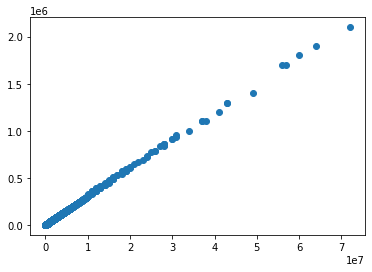

In [105]:
plt.scatter(ted['views'], ted['likes'])

intercept: 198.69644169940148
coefficient: [0.03027897]


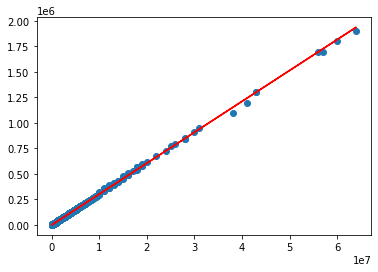

In [106]:
features = ['views']
x = ted[features]
y = ted['likes']
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3)
regressor = LinearRegression()
lin_reg = regressor.fit(X_train, y_train)

print('intercept:', lin_reg.intercept_)
print('coefficient:', lin_reg.coef_)

plt.scatter(X_train, y_train)

y_hat = X_train * lin_reg.coef_ + lin_reg.intercept_

plt.plot(X_train, y_hat, color='r') 

Sempre legato al numero di views e di likes, vogliamo andare a vedere quali sono i talks con il miglior rapporto `#likes/#views`.

In [107]:
ted['ratio']=ted['likes'].div(ted['views'])
ted.sort_values(by='ratio', ascending=False, ignore_index=True).nlargest(10, 'ratio')[['author', 'title']]

,author,title
0,Coby Everton,The importance of queer allyship in the classroom
1,Mackenzie Dalrymple,Three stories of Scotland
2,Mathieu Lamiaux,Imagining a new future for health systems in A...
3,Scott Nguyen,Solar energy can help put power back in the ha...
4,Paul S. Kindstedt,A brie(f) history of cheese
5,Tim Ferriss,Why you should define your fears instead of yo...
6,Emily Esfahani Smith,There's more to life than being happy
7,Alejandro Chaskielberg,Cómo usar el arte de la fotografía para restau...
8,Tony Buffington,Why do cats act so weird?
9,Rana Novack,How we'll predict the next refugee crisis


Andiamo a vedere quali sono gli autori che hanno prodotto il maggior numero di talks.

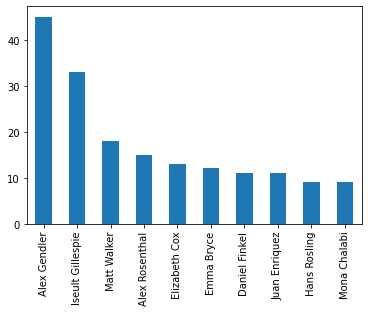

In [108]:
authorProduct = ted.sort_values(by='author')['author'].value_counts()
authorProductLimited = authorProduct.nlargest(10)
authorProductLimited.plot(kind='bar')

Adesso andiamo a vedere quali sono gli autori che hanno ottenuto il maggior numero di views.

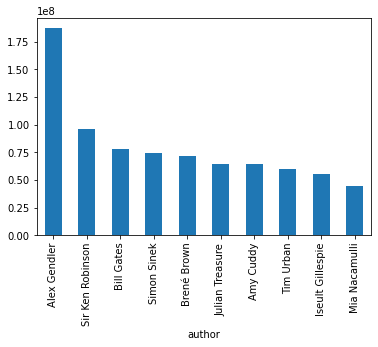

In [109]:
authorViews = ted.sort_values(by='author').groupby('author')['views'].sum() #normalizzazione
authorViewsLimited = authorViews.nlargest(10)
authorViewsLimited.plot(kind='bar')

Si può notare come, tranne Alex Gendler, la maggior parte degli autori con il maggior numero di views non corrispondano con quelli che hanno pubblicato più talks. Andiamo a vedere se è presente una correlazione tra il numero di talks pubblicati ed il numero di views di un autore.

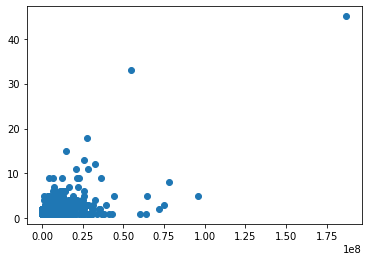

In [110]:
plt.scatter(authorViews, authorProduct.sort_index())

In [111]:
authorViews.sort_index().corr(authorProduct.sort_index())

0.6155446399849689

È possibile notare che è presente una moderata correlazione anche tra il numero di views registrate da un autore e dal numero di talks da lui pubblicati.

Adesso andiamo a vedere quali sono i 10 talks più guardati e con più like e chi è il loro autore.

In [112]:
bestTalksByViews = ted.sort_values(by='views', ascending=False, ignore_index=True).nlargest(10, 'views')[['author', 'title']]
bestTalksByViews

,author,title
0,Sir Ken Robinson,Do schools kill creativity?
1,Amy Cuddy,Your body language may shape who you are
2,Tim Urban,Inside the mind of a master procrastinator
3,Simon Sinek,How great leaders inspire action
4,Brené Brown,The power of vulnerability
5,Julian Treasure,How to speak so that people want to listen
6,Sam Berns,My philosophy for a happy life
7,Bill Gates,The next outbreak? We're not ready
8,Robert Waldinger,What makes a good life? Lessons from the longe...
9,Cameron Russell,"Looks aren't everything. Believe me, I'm a model."


In [113]:
bestTalksByLikes = ted.sort_values(by='likes', ascending=False, ignore_index=True).nlargest(10, 'likes')[['author', 'title']]
bestTalksByLikes

,author,title
0,Sir Ken Robinson,Do schools kill creativity?
1,Amy Cuddy,Your body language may shape who you are
2,Tim Urban,Inside the mind of a master procrastinator
3,Brené Brown,The power of vulnerability
4,Simon Sinek,How great leaders inspire action
5,Julian Treasure,How to speak so that people want to listen
6,Sam Berns,My philosophy for a happy life
7,Bill Gates,The next outbreak? We're not ready
8,Robert Waldinger,What makes a good life? Lessons from the longe...
9,Mary Roach,10 things you didn't know about orgasm


Si può notare come la maggior parte dei talks con più views corrispondano con quelli con più likes. È un risultato che ci aspettavamo siccome abbiamo visto in precedenza che è presente una forte correlazione tra il numero di views ed il numero di likes.

Adesso vogliamo andare a vedere se è presente una preferenza sui mesi dove pubblicare i talks.

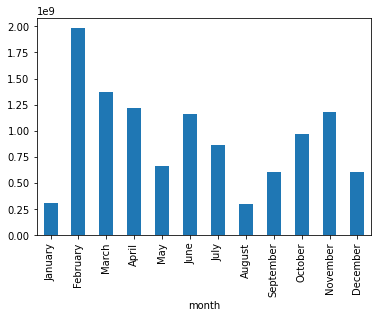

In [114]:
import calendar
ted['month'] = ted['date'].str.split(' ', expand=True)[0]

ted['month']=pd.Categorical(ted['month'], categories=list(calendar.month_name)[1::], ordered=True)
views = ted.sort_values(by='month').groupby('month')['views'].sum()

views.plot(kind='bar')

Si può notare come nei mesi dove sono presenti le festività (gennaio, agosto e dicembre) sono stati pubblicati il minor numero di talks.

Adesso andiamo a vedere l'andamento annuale di visualizzazioni e pubblicazioni di nuovi talks.

In [115]:
ted['year'] = ted['date'].str.split(' ', expand=True)[1]

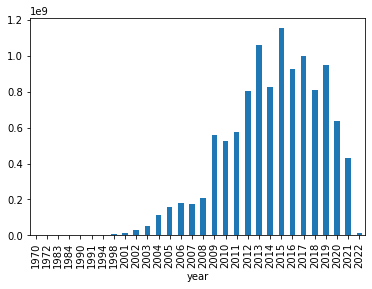

In [116]:
views = ted.groupby('year')['views'].sum()#/ted['views'].sum() #normalizzazione
views.plot(kind='bar')

È possibile notare come c'è stata una crescita nel numero di visualizzazioni sino al 2015, anno in cui si è raggiunto il picco, e successivamente sono calate. Andiamo a vedere se il 2015 coincide anche con una diminuzione nel numero di talks prodotti.

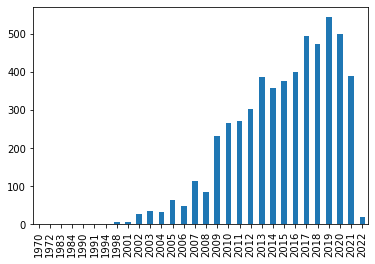

In [117]:
year = ted['year'].value_counts().sort_index()
year.plot(kind='bar')

È possibile notare come in realtà sino al 2019 sono stati prodotti un numero sempre maggiore di talks, quindi questo ci fa pensare che a partire dal 2015 la gente ha iniziato a perdere interesse siccome è presente un aumento di talks prodotti (sino al 2019), ma una diminuzione nelle views.
<br><br>
Per vedere meglio i risultati ottenuti, andiamo a creare un grafico contenente i due risultati ottenuti. In questo caso i dati vengono normalizzati. Vengono rappresentati con la riga rossa il numero di talks prodotti e con la riga blu il numero di views registrate.

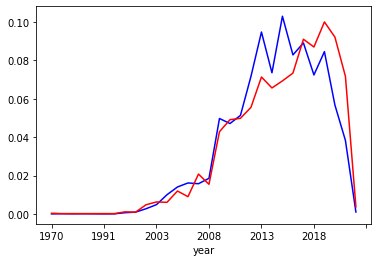

In [118]:
yearN = ted['year'].value_counts(normalize=True).sort_index()
viewsN = views.div(views.sum())

ax = viewsN.plot(kind='line', color='blue')
ax = yearN.plot(ax=ax, kind='line', color='red')

Vogliamo andare a vedere anche il numero medio di views per ogni anno.

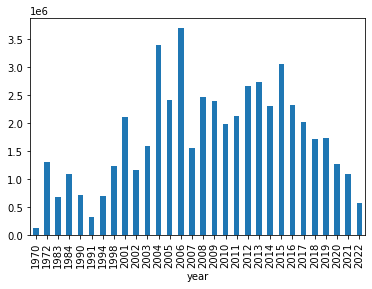

In [119]:
meanV = ted.groupby('year')['views'].mean().sort_index()
meanV.plot(kind='bar')

Si può notare come l'anno in cui i talks sono andati mediamente meglio è il 2005 ed a partire dal 2015 c'è stata una continua diminuzione nelle views (risultato visto anche in precedenza siccome dal 2015 al 2019 sono sempre aumentati il numero di talks prodotti, ma diminuivano le views).

Un altro tipo di analisi che vogliamo fare è sui titoli, infatti vogliamo vedere se sono presenti delle parole che compaiono la maggior parte delle volte per provare a trovare le tematiche più comuni.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
life       152
future     125
world      125
change     102
help        96
climate     89
make        89
art         83
need        81
power       79
Name: word, dtype: int64


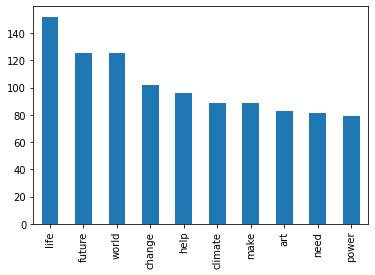

In [120]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
banned = list(stopwords.words('english'))+['—', 'new', 'us', 'could']


wordsList=[]
for v in ted['title'].values:
  for w in v.split():
    if w.lower() not in banned:
      wordsList.append(w.lower())
words = pd.DataFrame({'word':wordsList})
words['word'].value_counts().nlargest(10).plot(kind='bar') #TODO: VEDERE SE RIMUOVERE

print(words['word'].value_counts().nlargest(10))

Tra le paroli più comuni, si può notare come siano presenti, quasi nella stessa quantità, le parole `climate` e `change`, a suggerire come uno dei temi più importanti degli ultimi anni, ossia il cambiamento climatico, venga trattato molto frequentemente anche nei talks presenti su Ted Talks. Andiamo a verificare quante volte compaiono nello stesso titolo.

In [121]:
countBoth=0
countClimate=0
countChange=0
for v in ted['title'].values:
  v = v.lower()
  if 'climate' in v and 'change' in v:
    countBoth+=1
  if 'climate' in v:
    countClimate+=1
  if 'change' in v:
    countChange+=1

print(countBoth)
print(countClimate)
print(countChange)

48
92
136


Adesso andiamo a mostrare la distribuzione del numero di visualizzazioni

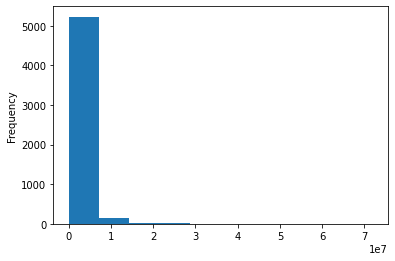

In [122]:
ted['views'].plot(kind='hist')

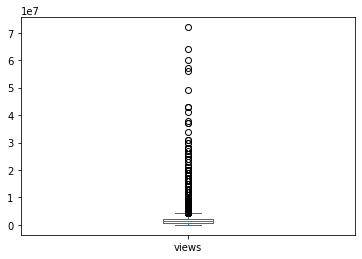

In [123]:
ted['views'].plot(kind='box')

Siccome la maggior parte dei talks ha meno di 1e7 visualizzazioni, per avere un grafico più leggibile, andiamo a separare i grafici dei talks con più di 1e7 visualizzazioni e con meno di 1e7 visualizzazioni.

Andiamo a vedere prima i grafici con più di 1e7 visualizzazioni

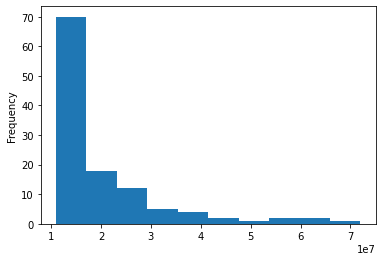

In [124]:
moreThan = np.where(ted['views']>1e7)[0]
ted['views'][moreThan].plot(kind='hist')

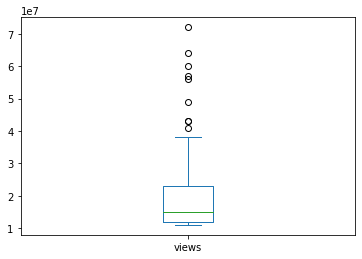

In [125]:
ted['views'][moreThan].plot(kind='box')

Adesso andiamo a vedere i grafici con meno di 1e7 visualizzazioni

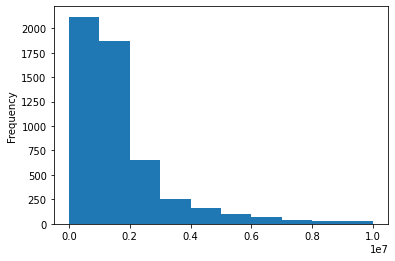

In [126]:
lessThan = np.where(ted['views']<=1e7)[0]
ted['views'][lessThan].plot(kind='hist')

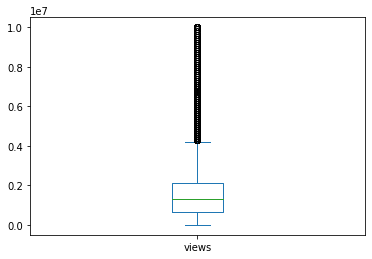

In [127]:
ted['views'][lessThan].plot(kind='box')